In [1]:
import warnings
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspy.plot import heatmap
from graspy.simulations import er_np, sbm
from graspy.utils import symmetrize
from joblib import Parallel, delayed
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu, truncnorm

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# def generate_pop(m, loc=0, block_1=5, block_2=15):
#     scale = 1/2.576
#     total_nodes = block_1 + block_2

#     arrs  = []
#     for _ in np.arange(m):
#         arr = np.zeros((total_nodes, total_nodes))
#         for i in range(total_nodes):
#             for j in range(i + 1, total_nodes):
#                 if (i < block_1) and (j < block_1):
#                     value = np.random.normal(loc, scale)
#                     while (value > 1) or (value < -1):
#                         value = np.random.normal(loc, scale)
#                     arr[i, j] = value
#                 else:
#                     value = np.random.normal(0, scale)
#                     while (value > 1) or (value < -1):
#                         value = np.random.normal(0, scale)
#                     arr[i, j] = value
#         arrs.append(symmetrize(arr, method='triu'))
        
#     out = np.stack(arrs)
#     return out

# def generate_data(m, mu1, mu2, seed=None):
#     np.random.seed(seed)
    
#     pop1 = generate_pop(m=m, loc=mu1)
#     pop2 = generate_pop(m=m, loc=mu2)
    
#     return pop1, pop2

In [55]:
def generate_pop(m, var_1, var_2, seed, block_1 = 5, block_2=15):
    np.random.seed(seed)

    n = [block_1, block_2]
    p = [
        [1, 1],
        [1, 1]
    ]
    sd_1 = np.sqrt(var_1)
    sd_2 = np.sqrt(var_2)
    
    wt_func = [
        [truncnorm.rvs, truncnorm.rvs],
        [truncnorm.rvs, truncnorm.rvs]
    ]
    
    wt_args_1 = [
        [dict(a=-1/sd_1, b=1/sd_1, scale=sd_1, random_state=seed), dict(a=-1/sd_1, b=1/sd_1, scale=sd_1, random_state=seed)],
        [dict(a=-1/sd_1, b=1/sd_1, scale=sd_1, random_state=seed), dict(a=-1/sd_1, b=1/sd_1, scale=sd_1, random_state=seed)],
    ]

    wt_args_2 = [
        [dict(a=-1/sd_2, b=1/sd_2, scale=sd_2, random_state=seed), dict(a=-1/sd_2, b=1/sd_2, scale=sd_2, random_state=seed)],
        [dict(a=-1/sd_2, b=1/sd_2, scale=sd_2, random_state=seed), dict(a=-1/sd_2, b=1/sd_2, scale=sd_2, random_state=seed)],
    ]
    
    pop_1 = np.array([sbm(n, p, wt=wt_func, wtargs=wt_args_1) for _ in range(m)])
    pop_2 = np.array([sbm(n, p, wt=wt_func, wtargs=wt_args_2) for _ in range(m)])
    
    return pop_1, pop_2

def compute_statistic(test, pop1, pop2):
    if test.__name__ == 'ttest_ind':
        test_statistics, _ = ttest_ind(pop1, pop2, axis=0)
        np.nan_to_num(test_statistics, copy=False)
    else:
        n = pop1.shape[-1]
        test_statistics = np.zeros((n, n))
        
        for i in range(n):
            for j in range(i, n):
                x_ij = pop1[:, i, j]
                y_ij = pop2[:, i, j]

                if np.array_equal(x_ij, y_ij):
                    test_statistics[i, j] = 0
                else:
                    tmp, pval = test(x_ij, y_ij)
                    test_statistics[i, j] = tmp
            
        test_statistics = symmetrize(test_statistics)
    
    return test_statistics

def compute_pr_at_k(different_n, k, test_statistics, test):
    n = test_statistics.shape[0]
    labels = np.zeros((n, n))
    labels[0:different_n, 0:different_n] = 1
    
    triu_idx = np.triu_indices_from(test_statistics, k=1)
    test_statistics_ = np.abs(test_statistics[triu_idx])
    labels_ = labels[triu_idx]
    
    if test.__name__ == 'ttest_ind':
        idx = np.argsort(test_statistics_)[::-1]
    else:
        idx = np.argsort(test_statistics_)
    sorted_labels = labels_[idx]
    
    precision_at_k = sorted_labels[:k].mean()
    recall_at_k = sorted_labels[:k].sum() / sorted_labels.sum()
    
    return precision_at_k, recall_at_k

def compute_trustworthiness(pvals):
    idx = np.triu_indices(pvals.shape[0], k=1)
    res = pvals[idx]
    
    fraction_correct = (res <=0.05).mean()
    all_correct = np.all(res <= 0.05)
    
    return fraction_correct, all_correct

In [63]:
def run_experiment(m, var_1, var_2, seed, reps):
    tests = ttest_ind, wilcoxon, mannwhitneyu
    
    precisions = []
    recalls = []
    
    for i in range(reps):
        tmp_precisions = []
        tmp_recalls = [] 
        pop1, pop2 = generate_pop(m=m, var_1=var_1, var_2=var_2, seed = seed+i)
        
        for test in tests:
            test_statistics = compute_statistic(test, pop1, pop2)
            
            for k in range(1, 11):
                precision, recall = compute_pr_at_k(5, k, test_statistics, test)
                tmp_precisions.append(precision)
                tmp_recalls.append(recall)

        precisions.append(tmp_precisions)
        recalls.append(tmp_recalls)
            
    precisions = np.array(precisions).mean(axis=0)
    recalls = np.array(recalls).mean(axis=0)
    
    to_append = [var_1, var_2, m, *precisions, *recalls]

    return to_append

In [35]:
spacing = 50
delta = 0.05

var_1s = np.linspace(1, 3, spacing)
var_2s = np.ones(spacing)        
ms = np.linspace(0, 500, spacing +1).astype(int)[1:]
reps=100

In [64]:
args = [
    (m, var_1, var_2, seed*reps, reps) 
    for seed, (m, (var_1, var_2)) 
    in enumerate(product(ms, zip(var_1s, var_2s)))
]

res = Parallel(n_jobs=-3, verbose=1)(
    delayed(run_experiment)(
        *arg
    ) for arg in args
)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 54 concurrent workers.
[Parallel(n_jobs=-3)]: Done  92 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-3)]: Done 342 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-3)]: Done 692 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-3)]: Done 1142 tasks      | elapsed: 75.5min
[Parallel(n_jobs=-3)]: Done 1692 tasks      | elapsed: 156.4min
[Parallel(n_jobs=-3)]: Done 2342 tasks      | elapsed: 290.4min
[Parallel(n_jobs=-3)]: Done 2500 out of 2500 | elapsed: 323.8min finished


In [65]:
cols =  [
    'var1',
    'var2',
    'm', 
    *[f"{test.__name__}_precision_at_{k}" for test in [ttest_ind, wilcoxon, mannwhitneyu]  for k in range(1, 11)], 
    *[f"{test.__name__}_recall_at_{k}" for test in [ttest_ind, wilcoxon, mannwhitneyu] for k in range(1, 11)]]
res_df = pd.DataFrame(res, columns = cols) 

In [66]:
res_df.to_csv("20200120_precision_recall_results.csv", index=False)

# Figures

In [70]:
res_df.ttest_ind_precision_at_10

0       0.000
1       0.046
2       0.041
3       0.037
4       0.037
        ...  
2495    0.051
2496    0.053
2497    0.044
2498    0.048
2499    0.050
Name: ttest_ind_precision_at_10, Length: 2500, dtype: float64

In [71]:
res_df.wilcoxon_precision_at_10

0       0.1
1       0.1
2       0.1
3       0.1
4       0.1
       ... 
2495    0.1
2496    0.1
2497    0.1
2498    0.1
2499    0.1
Name: wilcoxon_precision_at_10, Length: 2500, dtype: float64

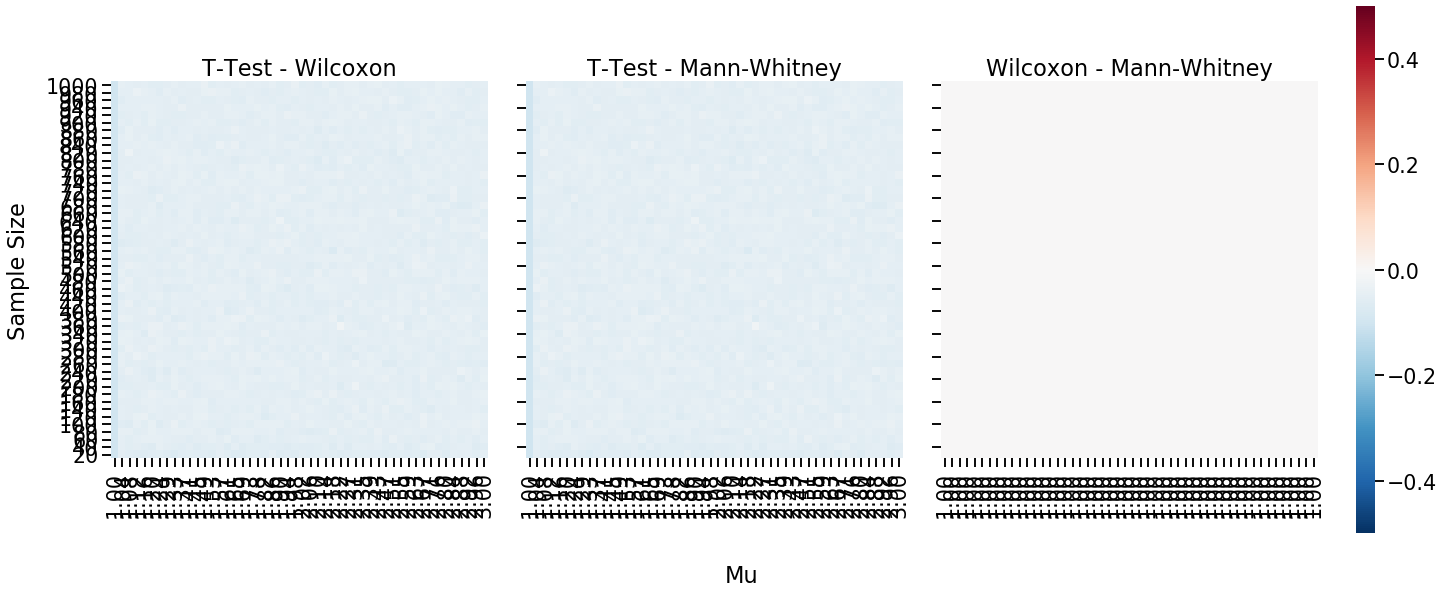

In [68]:
size = np.sqrt(res_df.shape[0]).astype(int)

ttest_prec = np.flipud(res_df.ttest_ind_precision_at_10.values.reshape(-1, spacing))
wilcoxon_prec = np.flipud(res_df.wilcoxon_precision_at_10.values.reshape(-1, spacing))
mannwhitney_prec = np.flipud(res_df.mannwhitneyu_precision_at_10.values.reshape(-1, spacing))

samples = np.linspace(0, 500, spacing +1).astype(int)[1:] *2
samples = [str(i) for i in samples]

vmin = -.5
vmax = -vmin


fmt = lambda x: "{:.2f}".format(x)
with sns.plotting_context('talk', font_scale=1.25):
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 0.05]}, figsize=(20, 8))
    
    sns.heatmap(
        ttest_prec - wilcoxon_prec,
        ax = ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in var_1s],
        yticklabels=[f"{int(m*2)}" for m in ms][::-1],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax
    )
    #ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1]+1, 10))
    #ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0]+1, 10)[::-1])
    ax[0].set_title("T-Test - Wilcoxon")
    
    sns.heatmap(
        ttest_prec - mannwhitney_prec,
        ax = ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in var_1s],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax
    )
    #ax[1].set_xticks(np.arange(0, ax[1].get_xlim()[1]+1, 10))
    #ax[1].set_yticks(np.arange(0, ax[1].get_ylim()[0]+1, 10)[::-1])
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].set_title("T-Test - Mann-Whitney")
    
    sns.heatmap(
        wilcoxon_prec - mannwhitney_prec,
        ax = ax[2],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in var_2s],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax
    )
    #ax[2].set_xticks(np.arange(0, ax[1].get_xlim()[1]+1, 10))
    #ax[2].set_yticks(np.arange(0, ax[1].get_ylim()[0]+1, 10)[::-1])
    ax[2].yaxis.set_major_formatter(plt.NullFormatter())
    ax[2].set_title("Wilcoxon - Mann-Whitney")

    fig.text(-0.01, 0.5, "Sample Size", va='center', rotation='vertical')
    fig.text(0.5, -0.03, "Mu", va='center', ha='center')
    
    fig.tight_layout()
    
    #fig.savefig("./figures/20191209_precision_diff.png", dpi=300, bbox_inches='tight')
    #fig.savefig("./figures/20191209_precision_diff.pdf", dpi=300, bbox_inches='tight')

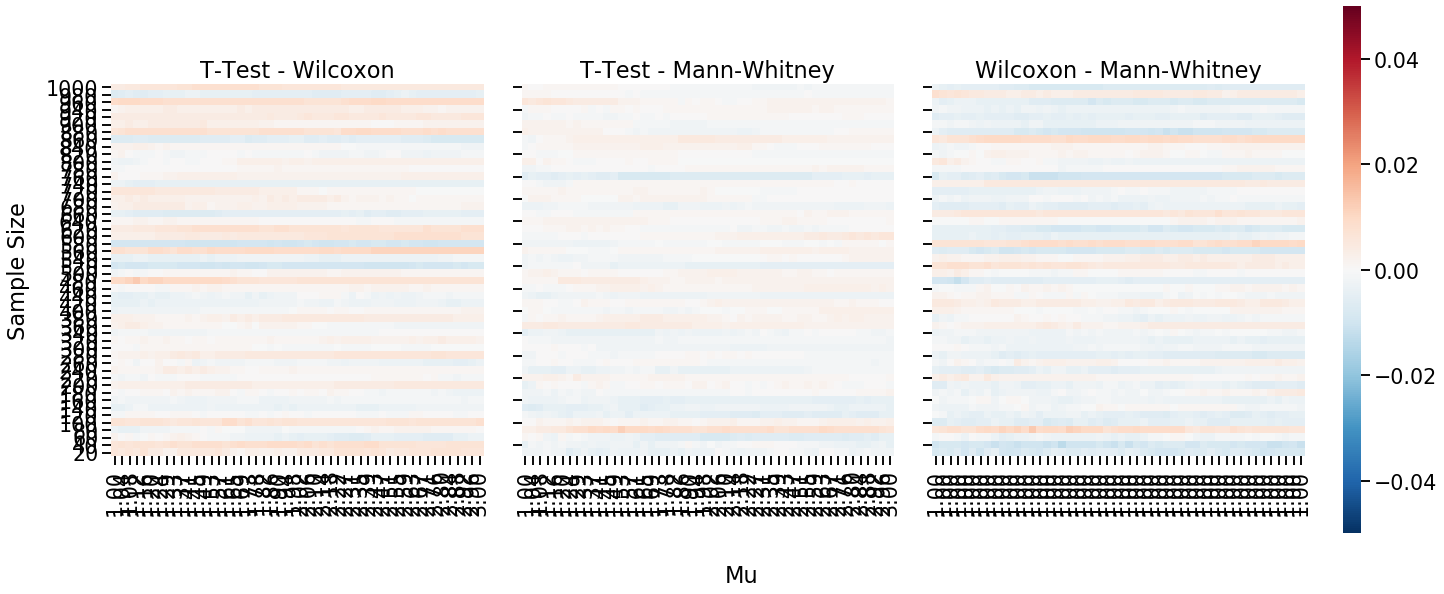

In [39]:
size = np.sqrt(res_df.shape[0]).astype(int)

ttest_prec = np.flipud(res_df.ttest_ind_precision_at_10.values.reshape(-1, spacing))
wilcoxon_prec = np.flipud(res_df.wilcoxon_precision_at_10.values.reshape(-1, spacing))
mannwhitney_prec = np.flipud(res_df.mannwhitneyu_precision_at_10.values.reshape(-1, spacing))

samples = np.arange(0, 501, spacing)[1:] *2
samples[0] += 10
samples = [str(i) for i in samples]

vmin = -0.05
vmax = -vmin


fmt = lambda x: "{:.2f}".format(x)
with sns.plotting_context('talk', font_scale=1.25):
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 0.05]}, figsize=(20, 8))
    
    sns.heatmap(
        ttest_prec - wilcoxon_prec,
        ax = ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in var_1s],
        yticklabels=[f"{int(m*2)}" for m in ms][::-1],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax
    )
    #ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1]+1, 10))
    #ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0]+1, 10)[::-1])
    ax[0].set_title("T-Test - Wilcoxon")
    
    sns.heatmap(
        ttest_prec - mannwhitney_prec,
        ax = ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in var_1s],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax
    )
    #ax[1].set_xticks(np.arange(0, ax[1].get_xlim()[1]+1, 10))
    #ax[1].set_yticks(np.arange(0, ax[1].get_ylim()[0]+1, 10)[::-1])
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].set_title("T-Test - Mann-Whitney")
    
    sns.heatmap(
        wilcoxon_prec - mannwhitney_prec,
        ax = ax[2],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in var_2s],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax
    )
    #ax[2].set_xticks(np.arange(0, ax[1].get_xlim()[1]+1, 10))
    #ax[2].set_yticks(np.arange(0, ax[1].get_ylim()[0]+1, 10)[::-1])
    ax[2].yaxis.set_major_formatter(plt.NullFormatter())
    ax[2].set_title("Wilcoxon - Mann-Whitney")

    fig.text(-0.01, 0.5, "Sample Size", va='center', rotation='vertical')
    fig.text(0.5, -0.03, "Mu", va='center', ha='center')
    
    fig.tight_layout()
    
    #fig.savefig("./figures/20191209_precision_diff.png", dpi=300, bbox_inches='tight')
    #fig.savefig("./figures/20191209_precision_diff.pdf", dpi=300, bbox_inches='tight')

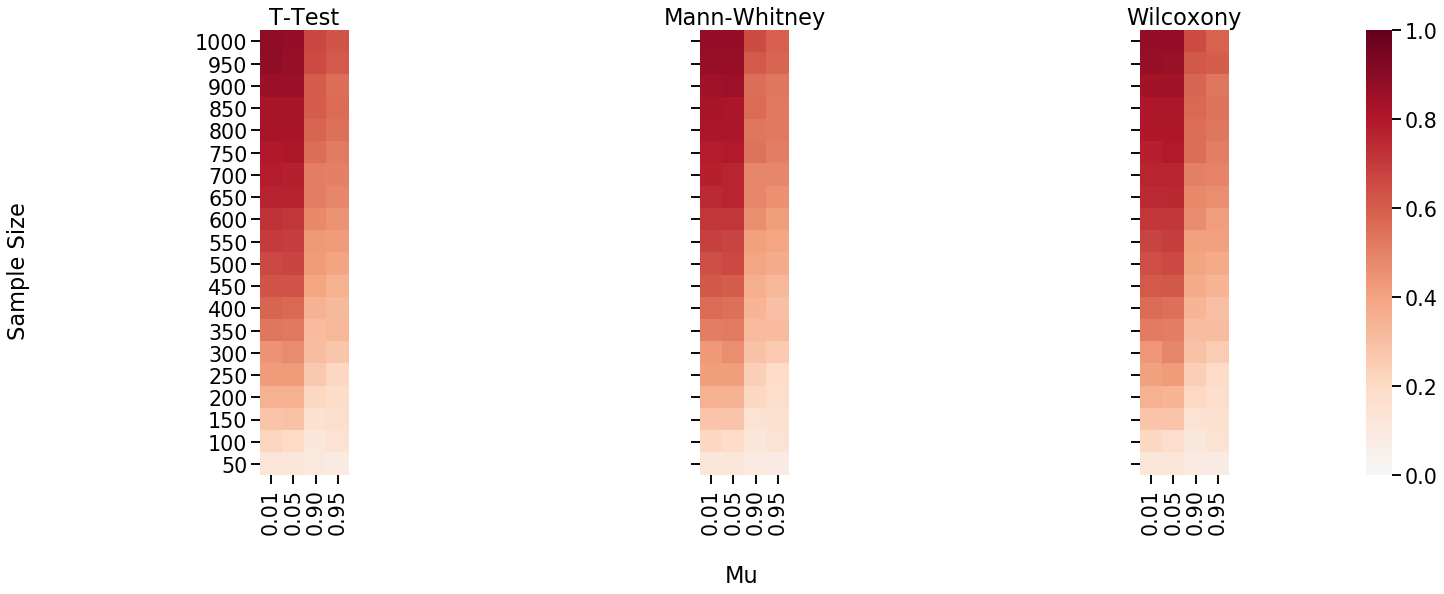

In [165]:
size = np.sqrt(res_df.shape[0]).astype(int)

ttest_prec = np.flipud(res_df.ttest_ind_precision_at_10.values.reshape(-1, 4))
wilcoxon_prec = np.flipud(res_df.wilcoxon_precision_at_10.values.reshape(-1, 4))
mannwhitney_prec = np.flipud(res_df.mannwhitneyu_precision_at_10.values.reshape(-1, 4))

samples = np.arange(0, 501, spacing) *2
samples[0] += 10
samples = [str(i) for i in samples]

vmin = 0
vmax = 1


fmt = lambda x: "{:.2f}".format(x)
with sns.plotting_context('talk', font_scale=1.25):
    # fig, ax = plt.subplots(figsize=(10, 10))
    fig, ax = plt.subplots(1, 4, gridspec_kw={'width_ratios': [1, 1, 1, 0.05]}, figsize=(20, 8))
    
    sns.heatmap(
        ttest_prec,
        ax = ax[0],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in mu1s],
        yticklabels=[f"{int(m*2)}" for m in ms][::-1],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax
    )
    #ax[0].set_xticks(np.arange(0, ax[0].get_xlim()[1]+1, 10))
    #ax[0].set_yticks(np.arange(0, ax[0].get_ylim()[0]+1, 10)[::-1])
    ax[0].set_title("T-Test")
    
    sns.heatmap(
        mannwhitney_prec,
        ax = ax[1],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in mu1s],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax
    )
    #ax[1].set_xticks(np.arange(0, ax[1].get_xlim()[1]+1, 10))
    #ax[1].set_yticks(np.arange(0, ax[1].get_ylim()[0]+1, 10)[::-1])
    ax[1].yaxis.set_major_formatter(plt.NullFormatter())
    ax[1].set_title("Mann-Whitney")
    
    sns.heatmap(
        wilcoxon_prec,
        ax = ax[2],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws = dict(shrink=0.7),
        xticklabels=[f"{mu1:.02f}" for mu1 in mu1s],
        cbar_ax=ax[-1],
        vmin=vmin,
        vmax=vmax
    )
    #ax[2].set_xticks(np.arange(0, ax[1].get_xlim()[1]+1, 10))
    #ax[2].set_yticks(np.arange(0, ax[1].get_ylim()[0]+1, 10)[::-1])
    ax[2].yaxis.set_major_formatter(plt.NullFormatter())
    ax[2].set_title("Wilcoxony")

    fig.text(-0.01, 0.5, "Sample Size", va='center', rotation='vertical')
    fig.text(0.5, -0.03, "Mu", va='center', ha='center')
    
    fig.tight_layout()
    
    #fig.savefig("./figures/20191209_precision_diff.png", dpi=300, bbox_inches='tight')
    #fig.savefig("./figures/20191209_precision_diff.pdf", dpi=300, bbox_inches='tight')